# ***Living Earth*** Categorical Descriptors: Intertidal <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_s2ls_intertidal_cyear_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2ls_intertidal_cyear_3)



## Selection of an area of interest and extraction of intertidal data

The DEA Intertidal product suite maps the changing elevation, exposure and tidal characteristics of Australia’s exposed intertidal zone, the complex zone that defines the interface between land and sea.  The product incorporates both the Sentinel-2 and Landsat data from 2016-2022, the product suite provides an annual 10 m resolution elevation product for the intertidal zone, enabling users to better monitor and understand some of the most dynamic regions of Australia’s coastlines. Utilising an improved tidal modelling capability, the product suite includes a continental scale mapping of intertidal exposure over time, enabling scientists and managers to integrate the data into ecological and migratory species applications and modelling.

For more information on the products visit: https://knowledge.dea.ga.gov.au/data/product/dea-intertidal/

To assist in the selection of your coordinates go to http://geojson.io.

## Description 

This notebook will demonstrate how to load up an area of interest and extract intertidal products (e.g., elevation) from the DEA product suite.

The notebooks take you through the process of:

1. Setting up.
2. Identifying an area from an interactive map. 
3. Establishing the time period (note that the DEA intertidal product is only available for 2016-2022). 
4. Load the data and compare over time; products include intertidal elevation (m) and exposure (%)

***

## Section 1 

In [1]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


added a new line here
another line
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)


## Select your area of interest
You can select any area around the coast of Australia but consider larger estuaries such as the Fitzroy in Queensland.  

In [2]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


89

### Select the time-period
Note that the intertidal suite was generated using Sentinel-2 and Landsat data from the period 2016-2022.  

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2016, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2022, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2016, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2022, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2016-01-01', '2022-12-31')


#### Load the intertidal elevation data suite from Digital Earth Australia

In [5]:
# Check if required variables are defined

if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Load and mask the Intertidal Elevation products (select measurement = elevation, elevation_uncertainty and exposure)
item = dc.load(
    product="ga_s2ls_intertidal_cyear_3", 
    output_crs="EPSG:3577",  
    resolution=(-25, 25),
    **query   
    )  

item = mask_invalid_data(item)
item = item.where(item!=0)

Lat Range: (-23.527217, -23.428968)
Lon Range: (150.585358, 150.7296)
Start Date: 2016-01-01 00:00:00
End Date: 2022-12-31 00:00:00
Query Parameters: {'y': (-23.527217, -23.428968), 'x': (150.585358, 150.7296), 'time': (datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2022, 12, 31, 0, 0))}


### View the intertidal elevation suite
Note that the dataset includes elevation, elevation uncertainty and tidal exposure.  There are other elements but these are the main ones to consider

In [6]:
item

<xarray.Dataset> Size: 112MB
Dimensions:                (time: 7, y: 521, x: 642)
Coordinates:
  * time                   (time) datetime64[ns] 56B 2016-07-01T23:59:59.9999...
  * y                      (y) float64 4kB -2.663e+06 -2.663e+06 ... -2.676e+06
  * x                      (x) float64 5kB 1.872e+06 1.872e+06 ... 1.888e+06
    spatial_ref            int32 4B 3577
Data variables:
    elevation              (time, y, x) float32 9MB nan nan nan ... nan nan nan
    elevation_uncertainty  (time, y, x) float32 9MB nan nan nan ... nan nan nan
    exposure               (time, y, x) float32 9MB nan nan nan ... nan nan nan
    ta_hat                 (time, y, x) float32 9MB 2.855 2.855 ... 3.035 3.035
    ta_hot                 (time, y, x) float32 9MB 2.707 2.707 ... 2.955 2.955
    ta_lot                 (time, y, x) float32 9MB -1.52 -1.52 ... -1.59 -1.59
    ta_lat                 (time, y, x) float32 9MB -2.613 -2.613 ... -2.664
    ta_offset_high         (time, y, x) float32 9MB 2.0 2.0 2.0 ... 1.0 1.0 1.0
    ta_offset_low          (time, y, x) float32 9MB 19.0 19.0 19.0 ... 18.0 18.0
    ta_spread              (time, y, x) float32 9MB 77.0 77.0 77.0 ... 79.0 79.0
    qa_ndwi_corr           (time, y, x) float32 9MB nan nan -0.03253 ... nan nan
    qa_ndwi_freq           (time, y, x) float32 9MB nan nan 20.0 ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Display the elevation data for your period of interest.
Note the different elevations of the intertidal zone (in m relative to modelled Mean Sea Level for each pixel of the satellite-observed exposed intertidal zone across the Australian coastline. The elevation model is generated from DEA Landsat and Sentinel-2 surface reflectance data from each 3-year composite period, utilising a pixel-based approach based on Ensemble Tidal Modelling. For every pixel, the time series of surface reflectance data is converted to the Normalised Difference Water Index (NDWI) and each observation tagged with the tidal height modelled at the time of acquisition by the satellite. A rolling median is applied from low to high tide to reduce noise (such as white water, sunglint, and non-tidal water level variability), then analysed to identify the tide height at which the pixel transitions from dry to wet. This tide height represents the elevation of the pixel.

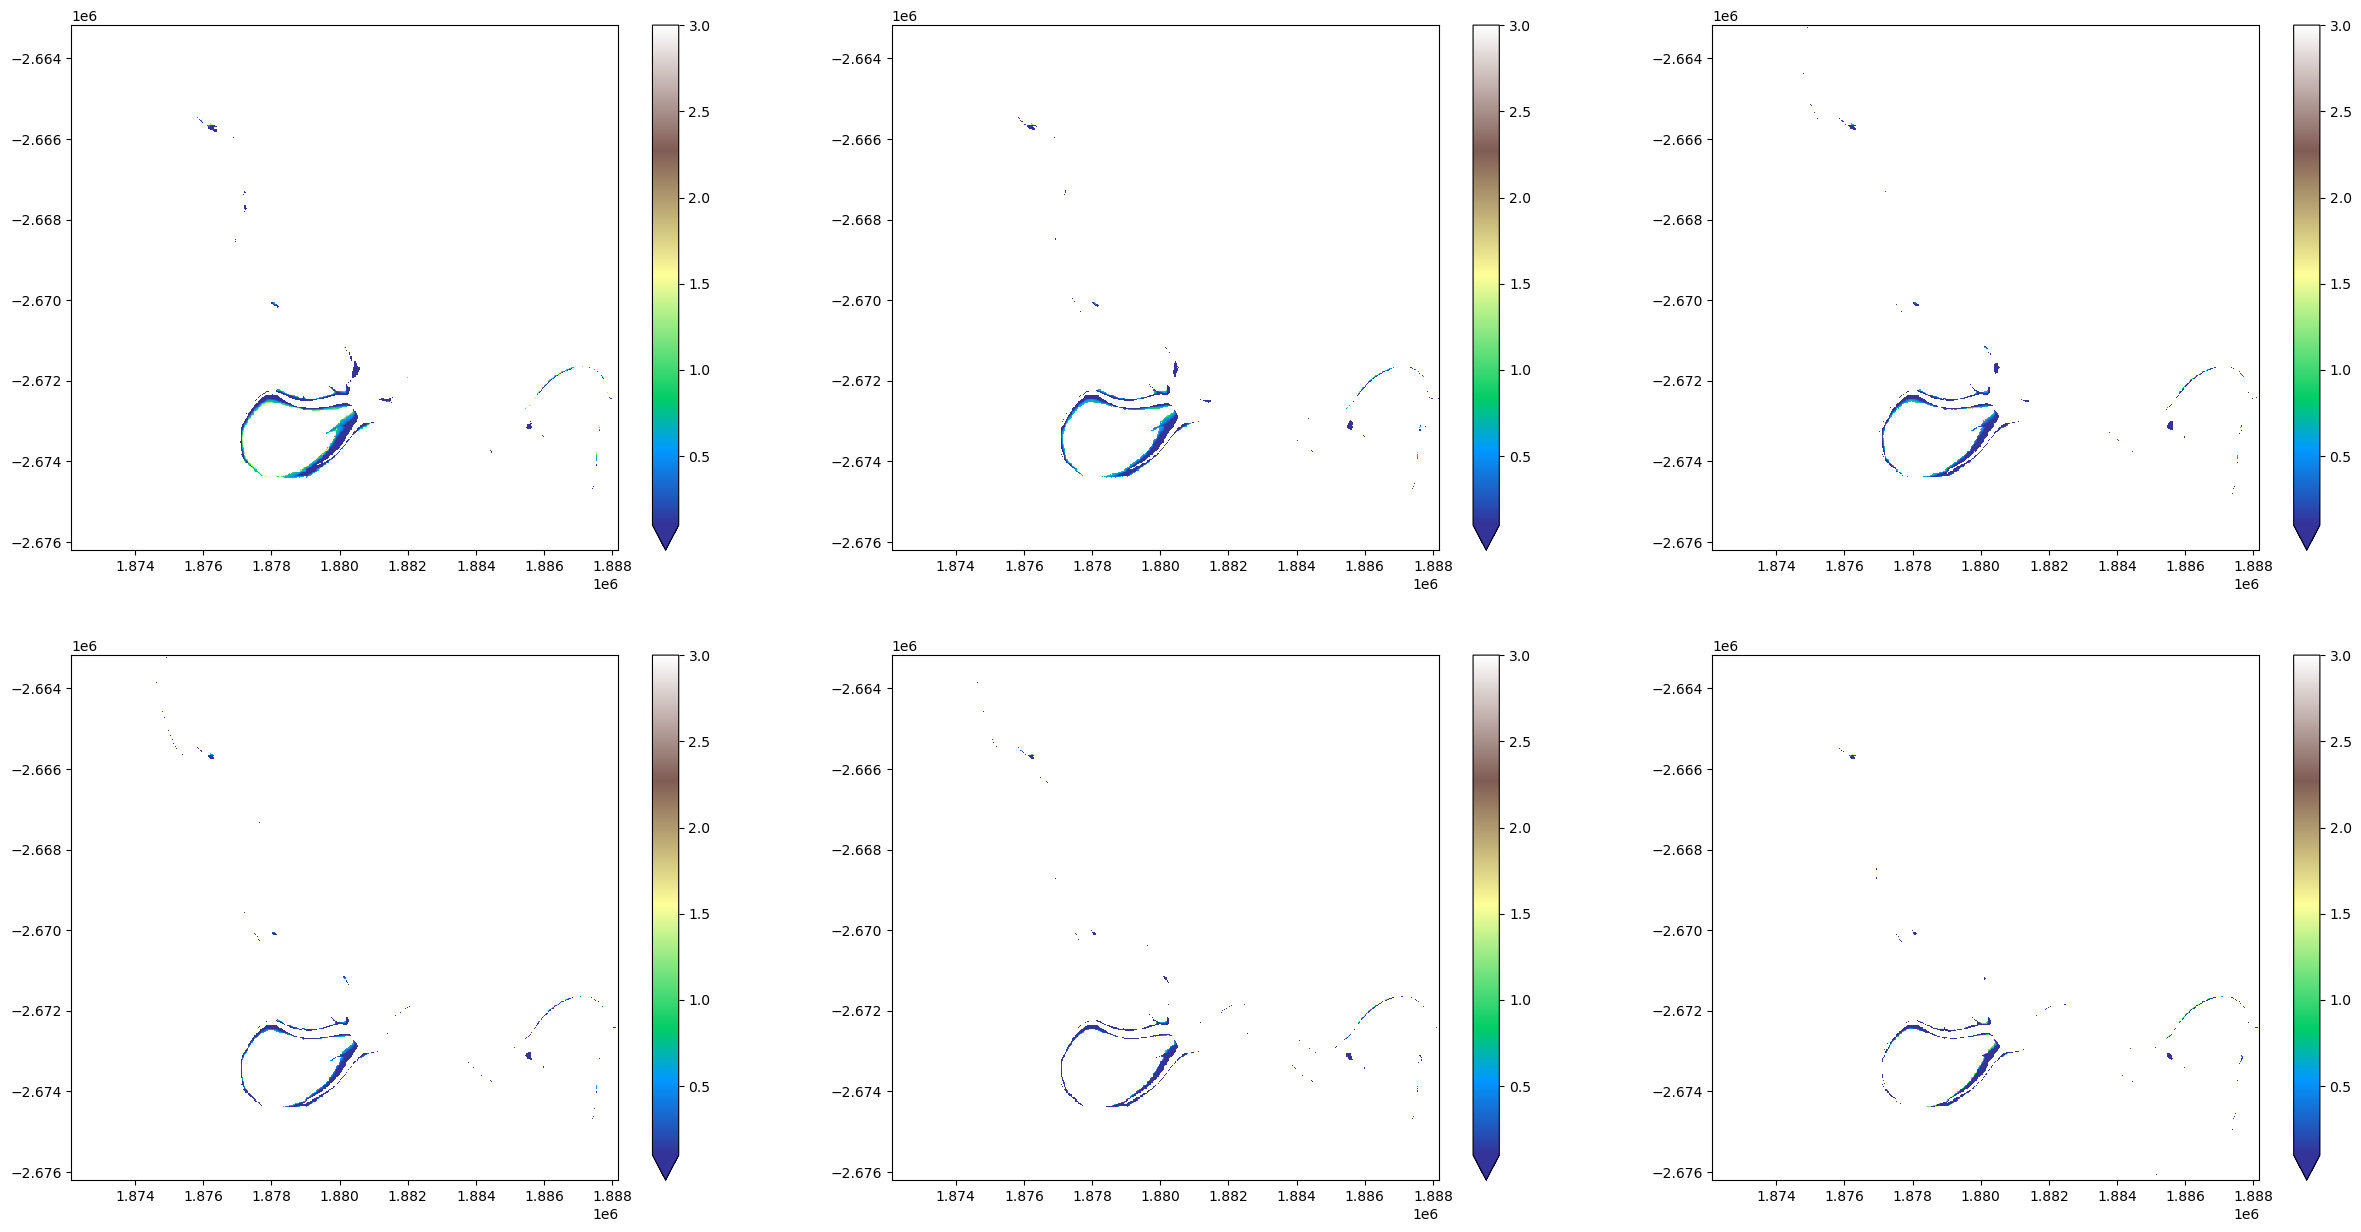

In [7]:
item_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 15))
item.elevation[0].plot(ax=axs[0,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[1].plot(ax=axs[0,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[2].plot(ax=axs[0,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[3].plot(ax=axs[1,0], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[4].plot(ax=axs[1,1], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')
item.elevation[5].plot(ax=axs[1,2], vmin = 0.1, vmax = 3, add_labels=False, cmap='terrain')

### Exploring the intertidal exposure
View the different exposures of the intertidal area. 

DEA's Intertidal Exposure models the percentage of time that any intertidal pixel of known elevation is exposed from tidal inundation. Exposure is calculated by comparing the pixel elevation back against a high temporal resolution model of tide heights for that location, based on the Ensemble Tidal Modelling approach. Exposure percentage is calculated as the fraction of exposed observations relative to the total number of observations generated in the high temporal resolution tidal model for the 3-year product epoch.

**Note:** You can change the range of the display using vmin and vmax and also the colour map [(cmap)](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

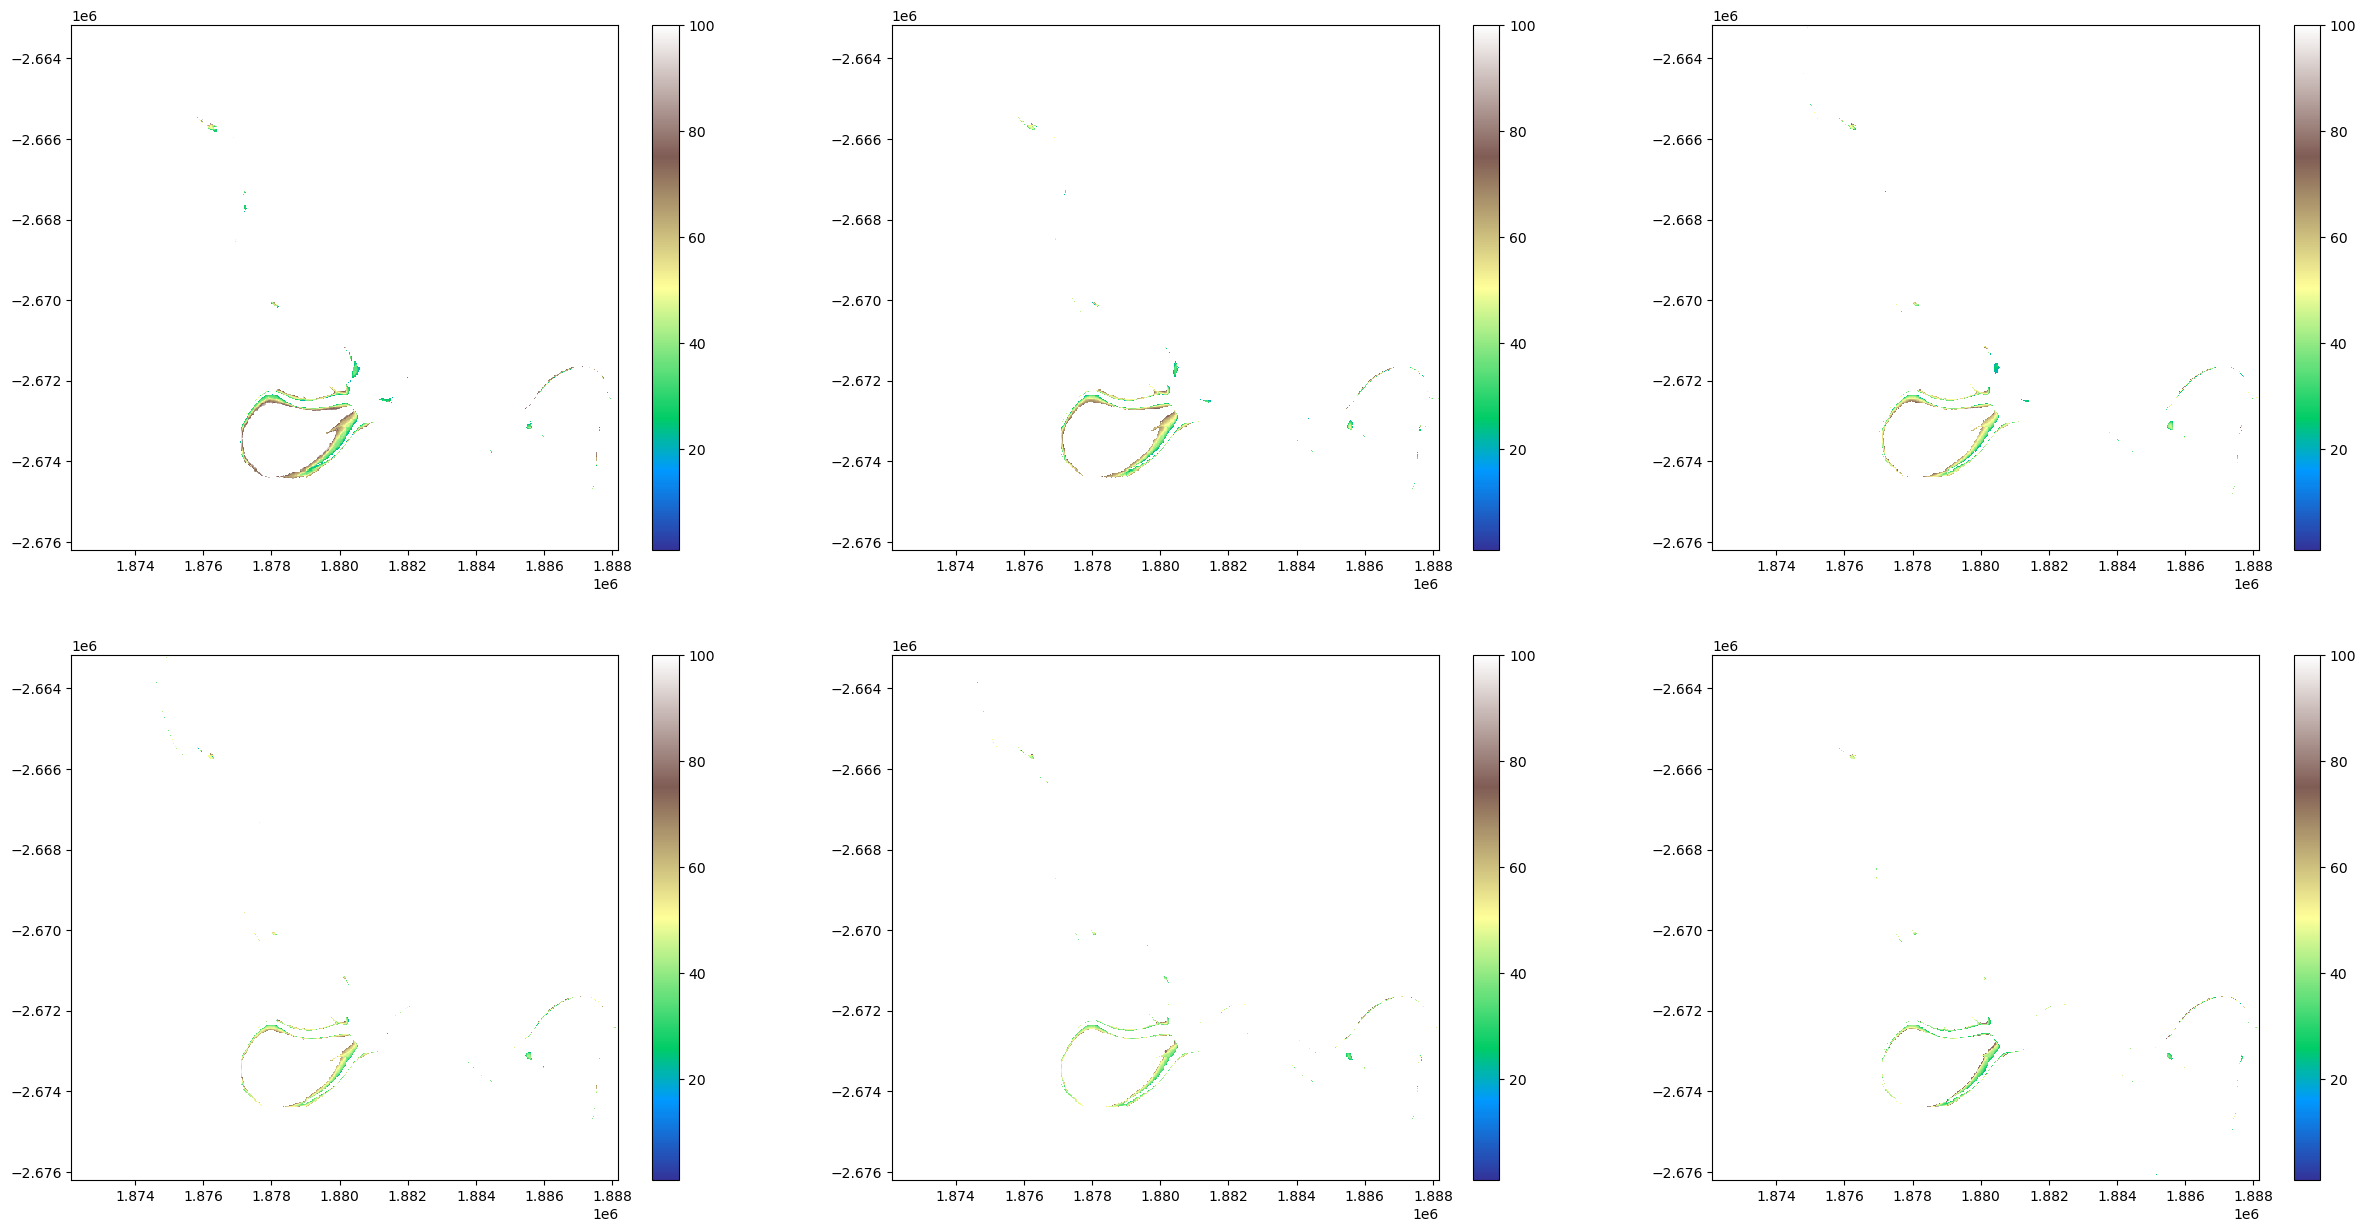

In [8]:
item_fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(30, 15))
item.exposure[0].plot(ax=axs[0,0], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')
item.exposure[1].plot(ax=axs[0,1], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')
item.exposure[2].plot(ax=axs[0,2], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')
item.exposure[3].plot(ax=axs[1,0], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')
item.exposure[4].plot(ax=axs[1,1], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')
item.exposure[5].plot(ax=axs[1,2], vmin = 1, vmax = 100, add_labels=False, cmap='terrain')

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`